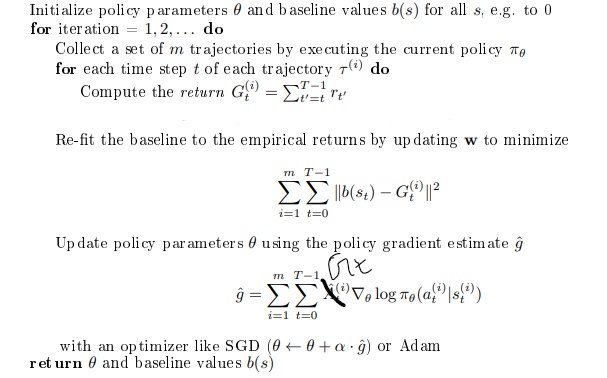

This is not a formal algorithm, there is no such thing called "dummy actor critic algorithm". This is just me testing some stuff out.

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distributions

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
train_env = gym.make("CartPole-v1")
test_env = gym.make("CartPole-v1")

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.dropout(self.fc1(x))
        x = F.relu(x)

        x = self.fc2(x)
        return x

In [ ]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        self.actor = actor
        self.critic = critic

    def forward(self, x):
        actions = self.actor(x)
        values = self.critic(x)

        return actions, values

In [ ]:
def init_parameters(p):
    if type(p) == nn.Linear:
        nn.init.xavier_normal_(p.weight)
        p.bias.data.fill_(0)

In [ ]:
def train(env, policy, gamma, opt):
    policy.train()
    ep_reward = 0
    values = []
    rewards = []
    log_prob_actions = []
    state = env.reset()
    done = False

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        actions, value_pred = policy(state)
        actions_softmax = F.softmax(actions, dim=-1)

        dist = distributions.Categorical(actions_softmax)
        action = dist.sample()
        log_prob_a = dist.log_prob(action)
        
        state, reward, done, _ = env.step(action.item())
        rewards.append(reward)
        log_prob_actions.append(log_prob_a)
        values.append(value_pred)
        ep_reward += reward

    log_prob_actions = torch.cat(log_prob_actions).to(device)
    values = torch.cat(values).squeeze(-1).to(device)
    returns = get_returns(rewards, gamma)

    actor_loss, critic_loss = update_policy(returns, log_prob_actions, values, opt)
    return actor_loss, critic_loss, ep_reward

In [ ]:
def get_returns(rewards, gamma):
    returns = []
    R = 0

    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    
    returns = torch.tensor(returns).to(device)
    returns = (returns - returns.mean()) / returns.std()
    return returns

In [ ]:
def update_policy(returns, log_prob_actions, values, opt):
    returns.detach_()
    actor_loss = - (returns * log_prob_actions).sum()
    critic_loss = F.smooth_l1_loss(returns, values).sum()

    opt.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    opt.step()
    
    return actor_loss.item(), critic_loss.item()

In [ ]:
def evaluate(env, policy):
    policy.eval()
    ep_reward = 0
    state = env.reset()
    done = False

    while not done:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            actions, _ = policy(state)
            action = torch.argmax(actions).item()

        state, reward, done, _ = env.step(action)
        ep_reward += reward

    return ep_reward

In [ ]:
episodes = 501
gamma = 0.99
input_size = train_env.observation_space.shape[0]
hidden_size = 128
output_size = train_env.action_space.n
lr = 1e-3

In [ ]:
actor = Net(input_size, hidden_size, output_size)
critic = Net(input_size, hidden_size, 1)
policy = ActorCritic(actor, critic)
policy.apply(init_parameters)
policy.to(device)

ActorCritic(
  (actor): Net(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (critic): Net(
    (fc1): Linear(in_features=4, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
opt = torch.optim.Adam(policy.parameters(), lr)

In [ ]:
actor_losses = []
critic_losses = []
train_rewards = []
test_rewards = []

In [ ]:
for ep in range(episodes):
    actor_loss, critic_loss, train_reward = train(train_env, policy, gamma, opt)
    test_reward = evaluate(test_env, policy)
    
    actor_losses.append(actor_loss)
    critic_losses.append(critic_loss)
    train_rewards.append(train_reward)
    test_rewards.append(test_reward)
    
    if ep % 50 == 0:
        al = sum(actor_losses) / len(actor_losses)
        cl = sum(critic_losses) / len(critic_losses)
        trr = sum(train_rewards) / len(train_rewards)
        ter = sum(test_rewards) / len(test_rewards)
        print(f"episode: {ep} | actor_loss: {al:.4f} | critic_loss: {cl:.4f} | train_reward: {trr} | test_reward: {ter}")

        actor_losses = []
        critic_losses = []
        train_rewards = []
        test_rewards = []

episode: 0 | actor_loss: 0.3735 | critic_loss: 0.4068 | train_reward: 14.0 | test_reward: 10.0
episode: 50 | actor_loss: 0.0481 | critic_loss: 0.4171 | train_reward: 27.44 | test_reward: 96.04
episode: 100 | actor_loss: -0.4323 | critic_loss: 0.3923 | train_reward: 39.82 | test_reward: 83.12
episode: 150 | actor_loss: -0.6345 | critic_loss: 0.4126 | train_reward: 50.06 | test_reward: 91.12
episode: 200 | actor_loss: -0.3699 | critic_loss: 0.3858 | train_reward: 64.78 | test_reward: 250.22
episode: 250 | actor_loss: -0.7989 | critic_loss: 0.3269 | train_reward: 90.2 | test_reward: 404.42
episode: 300 | actor_loss: -0.1340 | critic_loss: 0.2600 | train_reward: 155.92 | test_reward: 437.26
episode: 350 | actor_loss: -1.6368 | critic_loss: 0.2466 | train_reward: 240.56 | test_reward: 495.42
episode: 400 | actor_loss: -2.4642 | critic_loss: 0.2748 | train_reward: 314.64 | test_reward: 500.0
episode: 450 | actor_loss: 0.0420 | critic_loss: 0.2110 | train_reward: 357.8 | test_reward: 500.0
ep